In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
class TimeSeriesData():
    
    def __init__(self,num_points,xmin,xmax):
        
        self.xmin = xmin
        self.xmax = xmax
        self.num_points = num_points
        self.resolution = (xmax-xmin)/num_points
        self.x_data = np.linspace(xmin,xmax,num_points)
        self.y_true = np.sin(self.x_data)
    
    def ret_true(self,x_series):
        return np.sin(x_series)
    
    def next_batch(self,batch_size,steps,return_batch_ts=False):
        
        # Grab a random starting point for each batch
        rand_start = np.random.rand(batch_size,1) 
        
        # Convert to be on time series
        ts_start = rand_start * (self.xmax- self.xmin - (steps*self.resolution) )
        
        # Create batch Time Series on t axis
        batch_ts = ts_start + np.arange(0.0,steps+1) * self.resolution
        
        # Create Y data for time series in the batches
        y_batch = np.sin(batch_ts)
        
        # Format for RNN
        if return_batch_ts:
            return y_batch[:, :-1].reshape(-1, steps, 1), y_batch[:, 1:].reshape(-1, steps, 1) ,batch_ts
        
        else:
            
            return y_batch[:, :-1].reshape(-1, steps, 1), y_batch[:, 1:].reshape(-1, steps, 1) 
        

In [4]:
ts_data = TimeSeriesData(250,0,10)

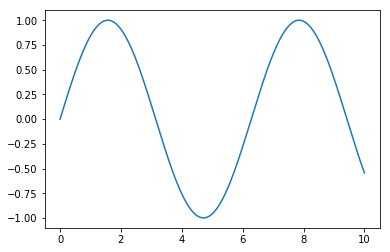

In [5]:
plt.plot(ts_data.x_data,ts_data.y_true)

In [6]:
num_time_steps = 30

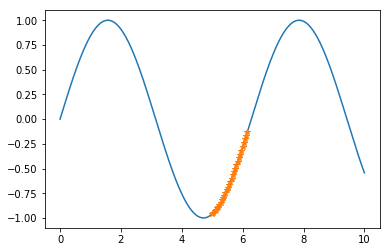

In [7]:
y1,y2,ts = ts_data.next_batch(1,num_time_steps, True)
plt.plot(ts_data.x_data,ts_data.y_true)
plt.plot(ts.flatten()[1:], y2.flatten(),'*')

In [7]:
# THE MODEL

In [8]:
tf.reset_default_graph()

In [8]:
# Constants
num_inputs = 1
num_neurons = 100
num_outputs = 1
learning_rate = 0.001
num_train_iterations = 2000
batch_size = 1

In [9]:
# Placeholder
x = tf.placeholder(tf.float32,[None,num_time_steps,num_inputs])
y = tf.placeholder(tf.float32,[None,num_time_steps,num_outputs])

In [10]:
# RNN layer
tmp = tf.contrib.rnn.GRUCell(
    num_units = num_neurons,
    activation=tf.nn.relu)

cell = tf.contrib.rnn.OutputProjectionWrapper(
    tmp,
    output_size=num_outputs)

In [11]:
outputs, states = tf.nn.dynamic_rnn(cell,x, dtype=tf.float32)

In [12]:
# Loss function 
loss = tf.reduce_mean(tf.square(outputs-y))

In [13]:
# Optimizer
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train = optimizer.minimize(loss)

In [14]:
init = tf.global_variables_initializer()

In [15]:
# Session
saver = tf.train.Saver()

In [17]:
with tf.Session() as sess:
    
    sess.run(init)
    
    for iteration in range(num_train_iterations):
        x_batch, y_batch = ts_data.next_batch(batch_size,num_time_steps)
        sess.run(train, feed_dict = {x:x_batch, y:y_batch})
        
        if iteration%100 == 0:
            mse = loss.eval(feed_dict = {x: x_batch, y : y_batch})
            print(iteration, "\tMSE",mse)
        
    saver.save(sess,"./rnn_time_series_model_codealong_anton")

0 	MSE 0.393168
100 	MSE 0.00117922
200 	MSE 0.0173545
300 	MSE 0.0131539
400 	MSE 0.00176342
500 	MSE 0.00210974
600 	MSE 0.00672281
700 	MSE 0.000462423
800 	MSE 0.0007518
900 	MSE 0.00745042
1000 	MSE 0.000223647
1100 	MSE 0.00167155
1200 	MSE 0.000109688
1300 	MSE 0.000351077
1400 	MSE 0.000551208
1500 	MSE 0.000391594
1600 	MSE 9.17211e-05
1700 	MSE 6.47377e-05
1800 	MSE 3.24306e-05
1900 	MSE 0.000328015


In [18]:
train_inst = np.linspace(5,5 + ts_data.resolution * (num_time_steps + 1), num_time_steps+1)
with tf.Session() as sess:
    saver.restore(sess,"./rnn_time_series_model_codealong_anton")
    
    x_new = np.sin(np.array(train_inst[:-1].reshape(-1,num_time_steps,num_inputs)))
    y_pred = sess.run(outputs, feed_dict={x:x_new})

INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_codealong_anton


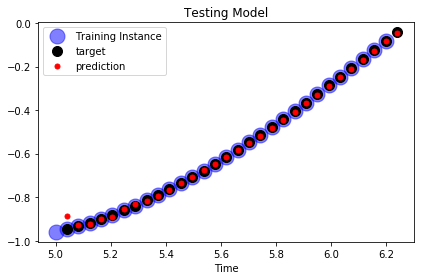

In [19]:
plt.title("Testing Model")

# Training Instance
plt.plot(train_inst[:-1], np.sin(train_inst[:-1]), "bo", markersize=15,alpha=0.5, label="Training Instance")

# Target to Predict
plt.plot(train_inst[1:], np.sin(train_inst[1:]), "ko", markersize=10, label="target")

# Models Prediction
plt.plot(train_inst[1:], y_pred[0,:,0], "r.", markersize=10, label="prediction")

plt.xlabel("Time")
plt.legend()
plt.tight_layout()

In [1]:
# GENERATE NEW SEQUENCE

In [16]:
with tf.Session() as sess:
    
    saver.restore(sess,"./rnn_time_series_model_codealong_anton")
    
    #Seed zeros
    zero_seq_seed = [0.0 for i in range(num_time_steps)]
    
    for iteration in range(len(ts_data.x_data)-num_time_steps):
        x_batch = np.array(zero_seq_seed[-num_time_steps:]).reshape(1,num_time_steps,1)
        y_pred = sess.run(outputs,feed_dict = {x: x_batch})
        zero_seq_seed.append(y_pred[0,-1,0])

INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_codealong_anton


Text(0,0.5,'Y')

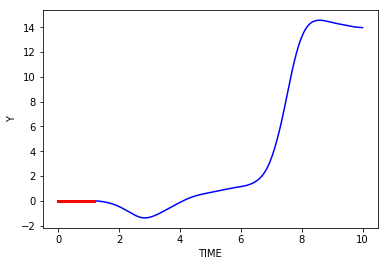

In [17]:
plt.plot(ts_data.x_data,zero_seq_seed,'b-')
plt.plot(ts_data.x_data[:num_time_steps],zero_seq_seed[:num_time_steps],'r',linewidth = 3)
plt.xlabel("TIME")
plt.ylabel("Y")